In [1]:
from pprint import pprint

import matplotlib.pyplot as plt

from rutils import AllLightningLogs, plot_val_and_test

In [2]:
logs = AllLightningLogs()

In [3]:
baseline_two_trainable_blocks = logs['baseline_2_trainable_blocks']

In [4]:
dinov3_salad_two_trainable_blocks = logs['dinov3_baseline_high']

In [5]:
dinov3_droplastblock_two_trainable_blocs = logs['dinov3_block10_high']

<div style="page-break-after: always;"></div>

## DINOv2 + SALAD

DINOv2+SALAD is model for Visual Place Recognition (VPR) introduced by Sergio Izquierdo and Javier Civera in [Optimal Transport Aggregation for Visual Place Recognition](https://arxiv.org/pdf/2311.15937). Currently, the SoTA for VPR and other related tasks is [MegaLoc](https://arxiv.org/pdf/2502.17237) which, in a nutshell, is DINOv2+SALAD with "steroids". DINO + SALAD uses DINOv2 as backbone, but they re-train the last $n$ layers and add an aggregator called SALAD which interaction is depicted in the following figure:

<img src="dino_salad.jpeg" alt="Centered Image" style="display: block; margin: 0 auto; width: 70%;">

### DINO

[DINO](https://arxiv.org/pdf/2104.14294) is a Vision Transformer (ViT) trained from scratch using Self Supervision Learning. Thanks of the self-supervised approach, and using a huge amount of data, DINO is a foundational model that extracts consistent both pixel-level and image-level properties over time, space, and semantically. Over time, Meta AI teams have improved their original work using (1) larger ViTs, (2) larger datasets with uncurated data, and (3) techniques that stabilize training during longer schedules.

DINO+SALAD from Optimal Transport Aggregation for Visual Place Recognition is built on DINOv2. Recently, Meta AI released the third version of this foundational model and showed that the -`CLS Token` of DINOv3 performs better than its counterpart from DINOv2 for Image Retrieval Tasks. So, I expect DINOv3+SALAD may outperform DINOv2+SALAD.

## Experiments
### Almost baseline

So far, I haven't replicated results from [Optimal Transport Aggregation for Visual Place Recognition](https://arxiv.org/pdf/2311.15937) because I've been working with 16GB of VRAM. My baseline model adopts all DINOv2+SALAD defaults but the number of trainable blocks, which I limited to 2. They show fine-tunning two DINOv2 blocks produces almost the same results that fine-tuning four DINOv2 blocks (see table 6 in the arxiv pre-print).

### Almost baseline, but with DINOv3

DINOv3-ViT-base is, in terms of architecture, almost the same as DINOv2-ViT-base (the backbone of the baseline). The major differences as the adoption in DINOv3 of RoPE positional embedding and the shift from 14x14 patch size (DINOv2) to 16x16 patch size (DINOv3). The latter means we must increase the resolution of the input images of DINOv3 in order to get the same amount of tokens and get a fair comparison, i.e., DINOv2+SALAD is trained using 224x224 images whilst DINOv3+SALAD is trained using 256x256 images. Note that by deviding by the size of the patches, both approaches produces 256 patch tokens.

Once it's said, the following plots depict the losses of both models on evaluation step for the Pitts30k Dataset.

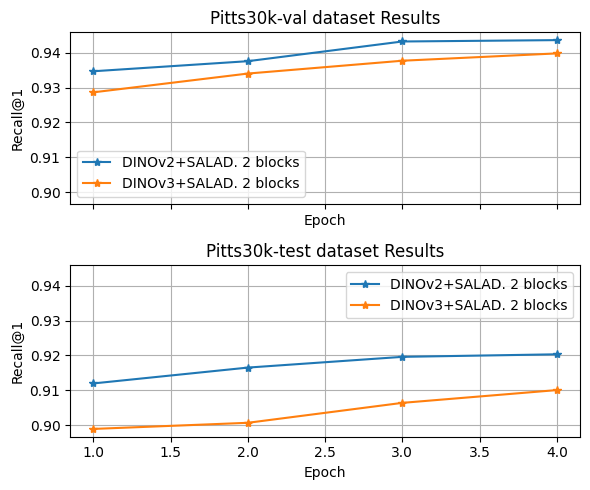

In [6]:
plot_val_and_test(
    [baseline_two_trainable_blocks, dinov3_salad_two_trainable_blocks], 
    ['DINOv2+SALAD. 2 blocks', 'DINOv3+SALAD. 2 blocks']
)

### Probing from block 11.

Well, it's kind of a dissapointment. However, after running some experiments, it turns out the block number 10 from DINOv3 - ViT - Base does it much better than using the last one. Note ViT - Base is a Transformer encoder of 12 blocks, so the last layer is the block number 11 (since we start counting from 0). For such a task, we drop the last block of DINOv3-ViT-Base and fine-tune the last two layers, i.e., the blocks number 9 and 10. We still connect the SALAD agregator layer and repeat the same training procedure.


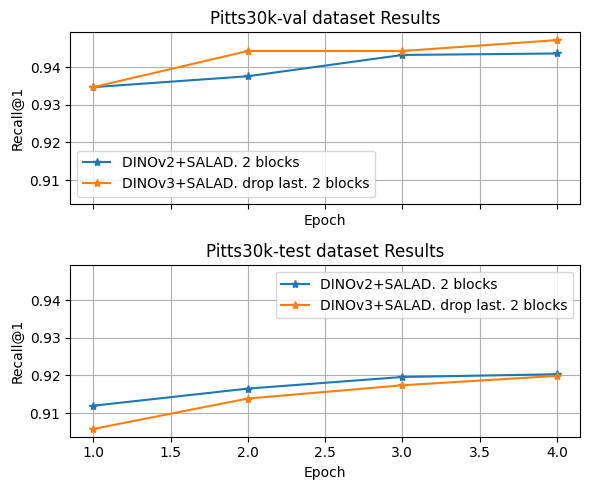

In [7]:
plot_val_and_test(
    [baseline_two_trainable_blocks, dinov3_droplastblock_two_trainable_blocs], 
    ['DINOv2+SALAD. 2 blocks', 'DINOv3+SALAD. drop last. 2 blocks']
)

#### Training for more epochs

This second model is more competitive on validation step. It not only performs better than DINOv2+SALAD in `Pitts30k-val` split, but is closing the gap in `Pitts30k-test`. It shows that, by running with more epochs, the performance in `Pitts30k-test` continuously increases.

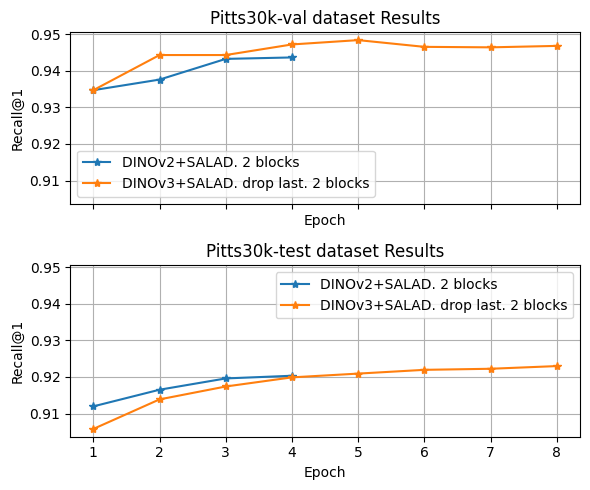

In [8]:
plot_val_and_test(
    [baseline_two_trainable_blocks, dinov3_droplastblock_two_trainable_blocs], 
    ['DINOv2+SALAD. 2 blocks', 'DINOv3+SALAD. drop last. 2 blocks'],
    True
)

## Testing my models

Now, let's freeze the models and test them using most of the datasets depicted in table 1 of 'Optimal Transport Aggregation for Visual Place Recognition' paper. Recall that I'm fine-tuning only the last 2 blocks instead of 4, so my DINOv2+SALAD model does not replicate the same stats shown in the table of theirs.

| model_name                        |   pitts30k_test_R1 |   pitts30k_test_R5 |   pitts250k_test_R1 |   pitts250k_test_R5 |   Nordland_R1 |   Nordland_R5 |   SPED_R1 |   SPED_R5 |
|:----------------------------------|-------------------:|-------------------:|--------------------:|--------------------:|--------------:|--------------:|----------:|----------:|
| DINOv2+SALAD. 2 blocks            |               **92.9** |               **96.8** |                **95.7** |                **98.7** |          70.9 |          85.2 |      89.5 |      **96**   |
| DINOv3+SALAD. drop last. 2 blocks |               92.6 |               96.4 |                95.3 |                98.5 |          **73.4** |          **86.4** |      **90.1** |      95.7 |

Code: https://github.com/L4rralde/dinov3_salad/tree/cimat

## Some parameters used


In [9]:
pprint(baseline_two_trainable_blocks.params)

{'agg_arch': 'SALAD',
 'agg_config': {'cluster_dim': 128,
                'num_channels': 768,
                'num_clusters': 64,
                'token_dim': 256},
 'backbone_arch': 'dinov2_vitb14',
 'backbone_config': {'norm_layer': True,
                     'num_trainable_blocks': 2,
                     'return_token': True},
 'batch_sampler': None,
 'batch_size': 60,
 'cities': ['Bangkok',
            'BuenosAires',
            'LosAngeles',
            'MexicoCity',
            'OSL',
            'Rome',
            'Barcelona',
            'Chicago',
            'Madrid',
            'Miami',
            'Phoenix',
            'TRT',
            'Boston',
            'Lisbon',
            'Medellin',
            'Minneapolis',
            'PRG',
            'WashingtonDC',
            'Brussels',
            'London',
            'Melbourne',
            'Osaka',
            'PRS'],
 'faiss_gpu': False,
 'image_size': [224, 224],
 'img_per_place': 4,
 'loss_name': 'MultiSimila

In [10]:
pprint(dinov3_salad_two_trainable_blocks.params)

{'agg_arch': 'SALAD',
 'agg_config': {'cluster_dim': 128,
                'num_channels': 768,
                'num_clusters': 64,
                'token_dim': 256},
 'backbone_arch': 'dinov3_vitb16',
 'backbone_config': {'norm_layer': True,
                     'num_trainable_blocks': 2,
                     'return_token': True,
                     'rope_sincos': True},
 'batch_sampler': None,
 'batch_size': 60,
 'cities': ['Bangkok',
            'BuenosAires',
            'LosAngeles',
            'MexicoCity',
            'OSL',
            'Rome',
            'Barcelona',
            'Chicago',
            'Madrid',
            'Miami',
            'Phoenix',
            'TRT',
            'Boston',
            'Lisbon',
            'Medellin',
            'Minneapolis',
            'PRG',
            'WashingtonDC',
            'Brussels',
            'London',
            'Melbourne',
            'Osaka',
            'PRS'],
 'faiss_gpu': False,
 'image_size': [256, 256],
 'img

In [11]:
pprint(dinov3_droplastblock_two_trainable_blocs.params)

{'agg_arch': 'SALAD',
 'agg_config': {'cluster_dim': 128,
                'num_channels': 768,
                'num_clusters': 64,
                'token_dim': 256},
 'backbone_arch': 'dinov3_vitb16',
 'backbone_config': {'norm_layer': True,
                     'num_trainable_blocks': 2,
                     'probing_from_layer': 10,
                     'return_token': True,
                     'rope_sincos': True},
 'batch_sampler': None,
 'batch_size': 60,
 'cities': ['Bangkok',
            'BuenosAires',
            'LosAngeles',
            'MexicoCity',
            'OSL',
            'Rome',
            'Barcelona',
            'Chicago',
            'Madrid',
            'Miami',
            'Phoenix',
            'TRT',
            'Boston',
            'Lisbon',
            'Medellin',
            'Minneapolis',
            'PRG',
            'WashingtonDC',
            'Brussels',
            'London',
            'Melbourne',
            'Osaka',
            'PRS'],
 'fais